Load and Explore Data

In [7]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt

# Load and Explore Data
data = pd.read_csv("Meteorite_Landings.csv")
print("Initial Dataset Info:")
print(data.info())
print(data.head())

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass (g)     45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45425 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB
None
       name   id nametype     recclass  mass (g)  fall    year    reclat  \
0    Aachen    1    Valid           L5      21.0  Fell  1880.0  50.77500   
1    Aarhus    2    Valid           H6     720.0  Fell  1951.0  56.18333   
2      Abee    6    Valid          EH4  107000.0  Fell  1952.0  54.216

Clean The Data

In [ ]:
# Drop rows with missing critical data (Latitute, longitude, mass, year)
data_cleaned = data.dropna(subset=['reclat', 'reclong', 'mass (g)', 'year'])

# Convert 'year' to an integer type and 'mass (g)' to float
data_cleaned['year'] = data_cleaned['year'].astype(int)
data_cleaned['mass (g)'] = data_cleaned['mass (g)'].astype(float)

# Check for duplicates and drop them
data_cleaned = data_cleaned.drop_duplicates()

C:\Users\shatha\AppData\Local\Temp\ipykernel_13596\453287237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['year'] = data_cleaned['year'].astype(int)
C:\Users\shatha\AppData\Local\Temp\ipykernel_13596\453287237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['mass (g)'] = data_cleaned['mass (g)'].astype(float)


Bin Year and Mass

In [ ]:
# Bin year into intervals
def bin_year(year):
    if year == 0:
        return 'Unknown'
    elif year < 1900:
        return 'Pre-1900'
    elif 1900 <= year < 2000:
        return '1900-2000'
    else:
        return 'Post-2000'

# Bin mass into categories
def bin_mass(mass):
    if mass == 0:
        return 'Unknown'
    elif mass < 1000:
        return 'Small'
    elif 1000 <= mass < 5000:
        return 'Medium'
    else:
        return 'Large'

data_cleaned['year_bin'] = data_cleaned['year'].apply(bin_year)
data_cleaned['mass_category'] = data_cleaned['mass (g)'].apply(bin_mass)


Visualize Year Bins

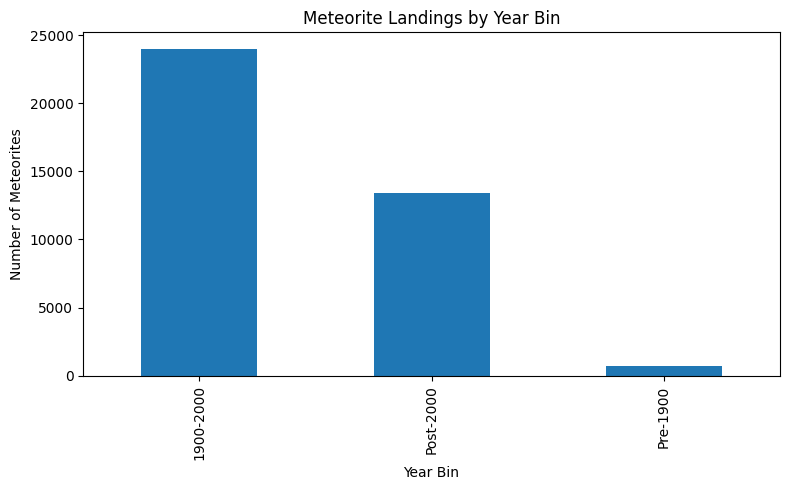

In [12]:
plt.figure(figsize=(8,5))
data_cleaned['year_bin'].value_counts().plot(kind='bar', title='Meteorite Landings by Year Bin')
plt.ylabel("Number of Meteorites")
plt.xlabel("Year Bin")
plt.tight_layout()
plt.show()

Association Rule Mining for Pre-1900

In [ ]:
# Filter data for pre-1900 meteorites
pre_1900_data = data_cleaned[data_cleaned['year_bin'] == 'Pre-1900']
pre_1900_transactions = pre_1900_data[['recclass', 'mass_category', 'fall', 'year_bin']].astype(str).values.tolist()

# Encode transactions
te = TransactionEncoder()
pre_1900_encoded = te.fit(pre_1900_transactions).transform(pre_1900_transactions)
pre_1900_df = pd.DataFrame(pre_1900_encoded, columns=te.columns_)

# Generate frequent itemsets and association rules
pre_1900_itemsets = apriori(pre_1900_df, min_support=0.05, use_colnames=True)
pre_1900_rules = association_rules(pre_1900_itemsets, metric="lift", min_threshold=1.0, num_itemsets=len(pre_1900_df))

print("Top Rules for Pre-1900 Meteorites:")
print(pre_1900_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())

Top Rules for Pre-1900 Meteorites:
                 antecedents               consequents   support  confidence  \
77             (Iron, IIIAB)            (Found, Large)  0.092068    0.822785   
72            (Found, Large)             (Iron, IIIAB)  0.092068    0.298165   
130            (Iron, IIIAB)  (Found, Large, Pre-1900)  0.092068    0.822785   
125  (Pre-1900, Iron, IIIAB)            (Found, Large)  0.092068    0.822785   
124           (Found, Large)   (Pre-1900, Iron, IIIAB)  0.092068    0.298165   

         lift  
77   2.664615  
72   2.664615  
130  2.664615  
125  2.664615  
124  2.664615  


c:\Users\shatha\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Association Rule Mining for 'Fell' Meteorites

In [ ]:
# Filter data for "Fell" meteorites
fell_data = data_cleaned[data_cleaned['fall'] == 'Fell']
fell_transactions = fell_data[['recclass', 'mass_category', 'fall', 'year_bin']].astype(str).values.tolist()

# Encode transcations
fell_encoded = te.fit(fell_transactions).transform(fell_transactions)
fell_df = pd.DataFrame(fell_encoded, columns=te.columns_)

# Generate frequent itemsets and association rules
fell_itemsets = apriori(fell_df, min_support=0.05, use_colnames=True)
fell_rules = association_rules(fell_itemsets, metric="lift", min_threshold=1.0, num_itemsets=len(fell_encoded))

print("Top Rules for 'Fell' Meteorites:")
print(fell_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())


Top Rules for 'Fell' Meteorites:
         antecedents            consequents   support  confidence      lift
123         (Medium)  (Fell, 1900-2000, L6)  0.050704    0.159292  1.178097
61          (Medium)        (1900-2000, L6)  0.050704    0.159292  1.178097
115  (1900-2000, L6)         (Medium, Fell)  0.050704    0.375000  1.178097
118   (Medium, Fell)        (1900-2000, L6)  0.050704    0.159292  1.178097
56   (1900-2000, L6)               (Medium)  0.050704    0.375000  1.178097


c:\Users\shatha\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


End of Notebook